In [1]:
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
import math
import numbers
import scipy as sp
import scipy.optimize as op
import pandas as pd
from scipy.interpolate import UnivariateSpline
import os
import sys
from IPython.display import display, Markdown


## Нелинейная краевая задача

Аристова, Завьялова, Лобанов, XI.9.16

![title](res/11-9-16.png)

In [2]:
t_begin = 0
t_end   = 120
y_begin = 0
y_end   = 0

def f(t, y, dydt):
    assert isinstance(t,    numbers.Number), "t must be scalar."
    assert isinstance(y,    numbers.Number), "y must be scalar."
    assert isinstance(dydt, numbers.Number), "dydt must be scalar."

    return 1 - np.exp(y)


### Метод стрельбы

In [3]:
def classicRK4(t0, y0, h, f, n_iter=None, t_end=None):
    '''
    Classic 4th order Runge-Kutta method.
    Buther tableau: https://en.wikipedia.org/w/index.php?title=Runge%E2%80%93Kutta_methods&oldid=1189959645.
    '''

    # Sanity checks.
    assert isinstance(t0, numbers.Number), "t0 must be scalar number"
    assert type(y0) is np.ndarray, "y0 must be numpy.ndarray"
    assert isinstance(h, numbers.Number), "h must be scalar number"
    assert type(f(t0, y0)) is np.ndarray, "function value must be numpy.ndarray"
    assert n_iter is None or t_end is None, "specify n_iter or t_end"

    if n_iter is None:
        n_iter = math.ceil((t_end - t_begin) / h)

    # Zero iteration.
    t = t0
    y = y0
    result_t = [t]
    result_y = [y]

    for i in range(n_iter):
        k1 = f(t        , y)
        k2 = f(t + 1/2*h, y + 1/2*k1*h)
        k3 = f(t + 1/2*h, y + 1/2*k2*h)
        k4 = f(t +     h, y +     k3*h)
        y = y + h*(1/6*k1 + 1/3*k2 + 1/3*k3 + 1/6*k4)

        t += h
        result_t.append(t)
        result_y.append(y)

    return np.array(result_t), np.array(result_y)


In [4]:
def shootingMethod(f, t_begin, y_begin, t_end, y_end, h,
                   precision=1e-5, max_iterations = 100,
                   a=None, df_dy=None, df_dydt=None):
    # Use slope as initial parameter if wasn't specified.
    if a == None:
        a = (y_end - y_begin) / (t_end - t_begin)

    # Use numerical derivatives if analytic weren't specified.
    if df_dy == None:
        df_dy = lambda t, y, dydt: (f(t, y + 1e-6, dydt) - f(t, y - 1e-6, dydt)) / (2e-6)
    if df_dydt == None:
        df_dydt = lambda t, y, dydt: (f(t, y, dydt + 1e-6) - f(t, y, dydt - 1e-6)) / (2e-6)

    for i in range(0, max_iterations):
        # print(f'{i=}, {a=}')

        # Solve pair of SODE simultaneously.
        # y_vec = [y, dy/dt, (dy/da), d/dt(dy/da)] = [y, z, u, v]
        f_vec = lambda t, y: np.array([
            y[1],
            f(t, y[0], y[1]),
            y[3],
            df_dy(t, y[0], y[1])*y[2] + df_dydt(t, y[0], y[1])*y[3]
        ])
        y0_vec = np.array([
            y_begin,
            a,
            0,
            1
        ])
        t, y_vec = classicRK4(t_begin, y0_vec, h, f_vec, t_end=t_end)

        y, z, u, v = list(zip(*y_vec))

        # Evaluate functional.
        F = y[-1] - y_end
        dFda = u[-1]
        # print(f"{F=}, {dFda=}")
        if np.abs(F) < precision:
            return t, y, a, i

        # Apply Newton method.
        a = a - F/dFda

Для $t \in [0; 120]$ существует три решения с периодами $T_1 = 120, \; T_2 = 60, \; T_3 = 30$.

Может показаться, что период, например, у $a = 60$ будет не 120, а 240. Однако, движение в положительных значениях координаты занимает малую часть от всего периода. Это видно, например, из $a = 30$.

==== Result ====
y[-1]=-7.061851701628541e-06, a=19.611799723090453, n_iters=4
y'(0)=19.611456296889433
y'(120)=18.92284168401023
==== Result ====
y[-1]=1.2592017916701614e-06, a=29.588698968826126, n_iters=3
y'(0)=29.588167477560265
y'(120)=29.38242619190285
==== Result ====
y[-1]=-8.964476383432896e-09, a=59.83833606546124, n_iters=2
y'(0)=59.83717350502452
y'(120)=59.11178210529708


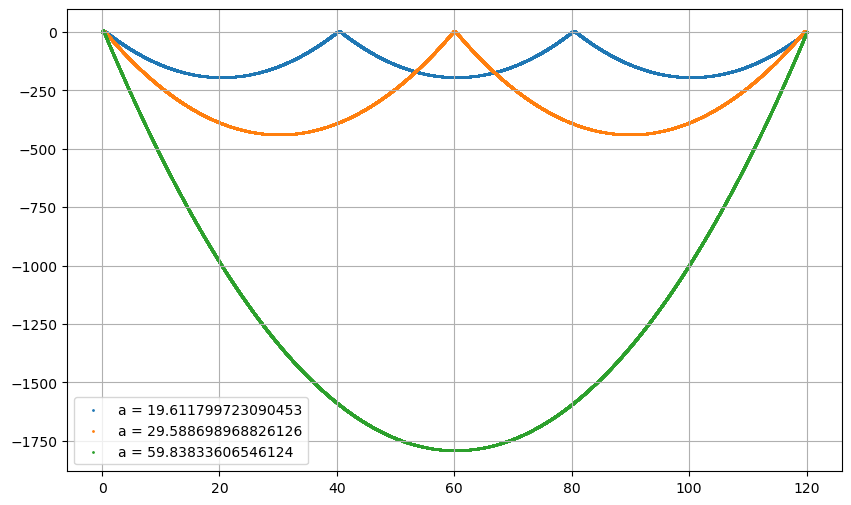

In [5]:
def displayResult(t, y, a, n_iters, draw=True):
    print(f"==== Result ====\n{y[-1]=}, {a=}, {n_iters=}")

    n = len(y)
    # t1 = 2
    # t2 = 3
    print(f"y'({t_begin})={(y[1] - y[0])/(t[1] - t[0])}")
    print(f"y'({t_end})={(y[-100] - y[-50])/(t[-100] - t[-50])}")
    print(f"================")

    if draw:
        plt.scatter(t, y, s=1, label=f"a = {a}")
        plt.grid()
        plt.legend()

draw = True
if draw:
    plt.figure(figsize=(10, 6))

t, y, a, n_iters = shootingMethod(f, t_begin, y_begin, t_end, y_end, a=19, h=0.01)
displayResult(t, y, a, n_iters, draw)
t, y, a, n_iters = shootingMethod(f, t_begin, y_begin, t_end, y_end, a=32, h=0.01)
displayResult(t, y, a, n_iters, draw)
t, y, a, n_iters = shootingMethod(f, t_begin, y_begin, t_end, y_end, a=61, h=0.01)
displayResult(t, y, a, n_iters, draw)

## Метод прогонки

Аристова, Завьялова, Лобанов, XI.9.5

![title](res/11-9-5.png)

In [6]:
h = 0.005
p = lambda x: 0
q = lambda x: -(10 + np.sin(2*np.pi*x))
f = lambda x: np.cos(2*np.pi*x)

In [7]:
def periodicTridiagonal(pk, qk, fk):
    N = len(fk)

    a = 1 - 1/2 * pk * h
    b = 2 - qk # * h**2
    c = 1 + 1/2 * pk * h
    phi = fk # * h**2

    alpha = np.ndarray(N)
    beta = np.ndarray(N)
    gamma = np.ndarray(N)

    alpha[1] = c[0]/b[0]
    beta[1] = -phi[0]/b[0]
    gamma[1] = a[0]/b[0]

    for k in range(1, N-1):
        alpha[k+1] = c[k]/(b[k] - alpha[k]*a[k])
        beta[k+1] = (a[k]*beta[k] - phi[k]) / (b[k] - alpha[k]/a[k])
        gamma[k+1] = a[k]*gamma[k] / (b[k] - alpha[k]*a[k])

    mu = np.ndarray(N)
    nu = np.ndarray(N)

    mu[N-1] = -c[N-1] / (a[N-1]*(alpha[N-1] + gamma[N-1]) - b[N-1])
    nu[N-1] = (phi[N-1] - a[N-1]*beta[N-1]) / (a[N-1]*(alpha[N-1] + gamma[N-1]) - b[N-1])

    for n in reversed(range(1, N)):
        mu[n-1] = alpha[n]*mu[n] + gamma[n]*mu[N-1]
        nu[n-1] = beta[n] + alpha[n]*nu[n] + gamma[n]*nu[N-1]

    y = np.ndarray(N)

    y[0] = nu[0] / (1 - mu[0])
    y[N-1] = mu[N-1]*y[0] + nu[N-1]

    for n in reversed(range(1, N)):
        y[n-1] = alpha[n]*y[n] + beta[n] + gamma[n]*y[N-1]

    return y

def solvePeriodic(p, q, f, h):
    T = 1.0
    N = int(T/h + 1)
    xk = np.array(np.linspace(0, 1, N))
    assert (xk[1] - xk[0]) <= h

    pk = np.array([p(x) for x in xk])
    qk = np.array([q(x) for x in xk])
    fk = np.array([f(x) for x in xk])

    yk = periodicTridiagonal(pk, qk, fk)

    return xk, yk

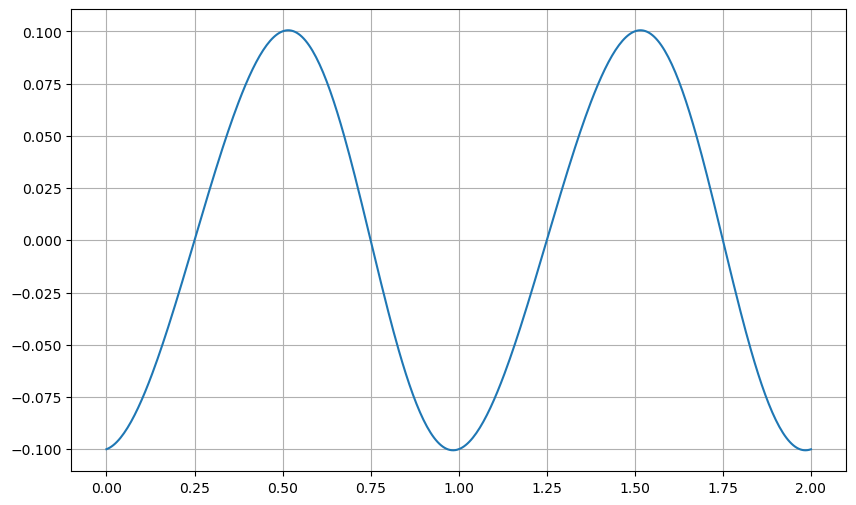

In [8]:
x, y = solvePeriodic(p, q, f, 0.005)

# Check that function is periodical.
n_periods = 2
y = np.tile(y, n_periods)
x = np.concatenate([x + i for i in range(0, n_periods)])

plt.figure(figsize=(10, 6))
plt.plot(x, y)
plt.grid()